# Genetic Algorithm

In [1]:
import random
import numpy as np

def genetic_algorithm(starting_population, cost_fn, crossover_fn, mutate_fn, drop_weakest=None,  
                      terminate_at_cost=None, terminate_at_generation=10000):
    """
    Arguments:
        starting_population (list): List of individuals in starting population. 
            The length of this list determines the population size used.
            List length must be divisible by 2.
        cost_fn (fn(individual) -> float): Determine cost of an individual, >= 0.
            Lower is better, 0 is perfect.
        drop_weakest (float, optional): If provided, drop this
            portion of each generation, without letting them breed.
        terminate_at_cost (float, optional): If an individual with a cost less than
            or equal to this value is produced, stop.
        terminate_at_generation (int, optional): Stop after this many generations.
    
    Returns:
        dict: results, in the form
            {
                "best": the fittest individual
                "best_cost": the cost of the fittest individual
                "cost_history": an np.array of shape 
                    (num_generations x population_size), containing the 
                    cost of every member of the population over generations.
            }
    """
    def weighted_pick(items, key=lambda x: x):
        random.shuffle(items)
        weight_total = sum((key(item) for item in items))
        n = random.uniform(0, weight_total)
        for item in items:
            weight = key(item)
            if n < weight:
                return item
            n = n - weight
        return item
    
    population = starting_population
    population_size = len(population)
    assert(population_size % 2 == 0)

    cost_history = []

    for generation in range(terminate_at_generation):
        # determine costs of population
        costs = [cost_fn(p) for p in population]
        cost_history.append(costs)
        
        if terminate_at_cost is not None and min(costs) <= terminate_at_cost:
            return {
                "best": population[costs.index(min(costs))],
                "best_cost": min(costs),
                "cost_history": np.array(cost_history)
            }

        # fitness is the inverse of cost
        MIN_COST = 0.000000001
        fitnesses = [(p, 1 / max(c, MIN_COST)) for p, c in zip(population, costs)]
            
        # remove the weakest from the gene pool
        if drop_weakest:
            fitnesses = sorted(fitnesses, key=lambda x: x[1])
            fitnesses = fitnesses[int(drop_weakest * population_size):]

        # create next generation
        population = []
        for i in range(population_size // 2):
            # individuals with higher fitnesses are more likely to breed
            parent1 = weighted_pick(fitnesses, key=lambda x: x[1])[0]
            parent2 = weighted_pick(fitnesses, key=lambda x: x[1])[0]

            # create children
            child1, child2 = crossover_fn(parent1, parent2)

            # mutate children
            population.append(mutate_fn(child1))
            population.append(mutate_fn(child2))

    # determine best
    best, cost = min(zip(population, [cost_fn(p) for p in population]), key=lambda x: x[1])

    return {
        "best": best,
        "best_cost": cost,
        "cost_history": np.array(cost_history)
    }

## Example Usage

In [2]:
import string
import editdistance

def random_gene():
    """ generate a random gene """
    return random.choice(string.printable)


def random_dna():
    """ generate a random DNA """
    return [random_gene() for i in range(len("Hello, World!"))]


def random_population():
    """ generate a population of random DNA """
    population_size = 20
    return [random_dna() for j in range(population_size)]


def cost(dna):
    """ evaluate fitness of DNA. Lower is better, 0 is perfect """
    return editdistance.eval("".join(dna), "Hello, World!")


def mutate(dna):
    """ randomly (maybe) mutate DNA """
    mutation_rate = 0.01
    return [random_gene() if random.random() < mutation_rate else x for x in dna]


def crossover(dna1, dna2):
    """ randomly crossover genes from two DNAs """
    return zip(*[(c1, c2) if random.random() < 0.5 else (c2, c1) for c1, c2 in zip(dna1, dna2)])

results = genetic_algorithm(**{
    "starting_population": random_population(), 
    "cost_fn": cost,
    "mutate_fn": mutate,
    "crossover_fn": crossover,
    "terminate_at_cost": 0,
    "terminate_at_generation": 10000,
    "drop_weakest": .05
})

best = "".join(results["best"])
best_cost = results["best_cost"]
num_gen = len(results["cost_history"])
print("Fittest after {num_gen} iterations: '{best}' (cost {best_cost})".format(**vars()))

Fittest after 2611 iterations: 'Hello, World!' (cost 0)


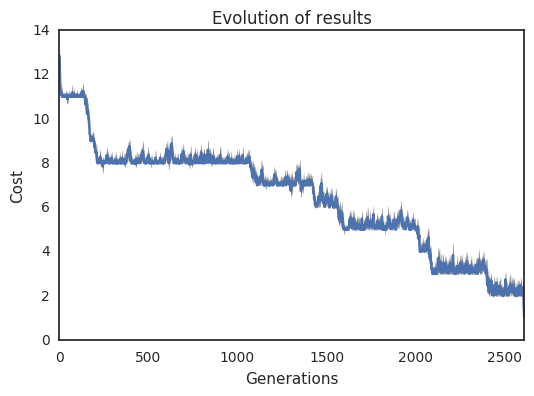

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
%matplotlib inline

sns.tsplot(results["cost_history"].T, ci=[68, 95, 99])
plt.ylabel("Cost")
plt.xlabel("Generations")
plt.title("Evolution of results")